<a href="https://colab.research.google.com/github/shivammehta007/QuestionGenerator/blob/master/ResearchReportSem4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Installing FairSeq

In [1]:
!pip install fairseq

     |████████████████████████████████| 307kB 12.9MB/s 
     |████████████████████████████████| 61kB 9.3MB/s 
     |████████████████████████████████| 17.1MB 197kB/s 
  Created wheel for fairseq: filename=fairseq-0.9.0-cp36-cp36m-linux_x86_64.whl size=2033637 sha256=f6ad1414149d9204125b63910ccd58af344d4c7ea167ec91dd205aa9af1c44cf
  Stored in directory: /root/.cache/pip/wheels/37/3e/1b/0fa30695dcba41e4b0088067fa40f3328d1e8ee78c22cd4766
Successfully built fairseq


# Download dataset from Kaggle

In [0]:
import os
import json

kaggle_info = json.load(open("/content/drive/My Drive/kaggle.json"))
os.environ['KAGGLE_USERNAME'] = kaggle_info["username"]
os.environ['KAGGLE_KEY'] = kaggle_info["key"]


In [3]:
!kaggle datasets list --user devicharith

ref                                             title                                  size  lastUpdated          downloadCount  
----------------------------------------------  -------------------------------------  ----  -------------------  -------------  
devicharith/language-translation-englishfrench  Language Translation (English-French)   4MB  2020-04-08 11:35:32             13  


In [4]:
!kaggle datasets download devicharith/language-translation-englishfrench

  0% 0.00/3.51M [00:00<?, ?B/s]
100% 3.51M/3.51M [00:00<00:00, 58.3MB/s]


In [5]:
!unzip language-translation-englishfrench.zip

Archive:  language-translation-englishfrench.zip
  inflating: eng_-french.csv         


## Preparing the dataset

In [0]:
import csv

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

In [0]:
dataset = pd.read_csv("eng_-french.csv")

In [8]:
dataset.head()

,English words/sentences,French words/sentences
0,Hi.,Salut!
1,Run!,Cours !
2,Run!,Courez !
3,Who?,Qui ?
4,Wow!,Ça alors !


In [9]:
trainset, testset = train_test_split(dataset, test_size=0.15, random_state=1234)
trainset, validset = train_test_split(trainset, test_size=0.1, random_state=1234)
trainset.shape, testset.shape, validset.shape

((134349, 2), (26344, 2), (14928, 2))

In [0]:
%mkdir dataset

In [0]:
def write(dataframe, dataset_name, folder="dataset"):
    en = dataframe["English words/sentences"]
    french = dataframe["French words/sentences"]
    en.to_csv('{}/{}.en'.format(folder, dataset_name), index=False, header=False, escapechar=" ", quoting=csv.QUOTE_NONE)
    french.to_csv('{}/{}.fr'.format(folder, dataset_name), index=False, header=False, escapechar=" ", quoting=csv.QUOTE_NONE)

In [0]:
write(trainset, "train")
write(testset, "valid")
write(validset, "test")

## Preprocessing 

In [13]:
!fairseq-preprocess --source-lang en --target-lang fr \
     --trainpref dataset/train --testpref dataset/test --validpref dataset/valid\
     --destdir preprocessed_data --seed 1234 --nwordssrc 25000 --nwordstgt 25000

Namespace(align_suffix=None, alignfile=None, bpe=None, cpu=False, criterion='cross_entropy', dataset_impl='mmap', destdir='preprocessed_data', empty_cache_freq=0, fp16=False, fp16_init_scale=128, fp16_scale_tolerance=0.0, fp16_scale_window=None, joined_dictionary=False, log_format=None, log_interval=1000, lr_scheduler='fixed', memory_efficient_fp16=False, min_loss_scale=0.0001, no_progress_bar=False, nwordssrc=25000, nwordstgt=25000, only_source=False, optimizer='nag', padding_factor=8, seed=1234, source_lang='en', srcdict=None, target_lang='fr', task='translation', tensorboard_logdir='', testpref='dataset/test', tgtdict=None, threshold_loss_scale=None, thresholdsrc=0, thresholdtgt=0, tokenizer=None, trainpref='dataset/train', user_dir=None, validpref='dataset/valid', workers=1)
| [en] Dictionary: 23319 types
| [en] dataset/train.en: 134349 sents, 969752 tokens, 0.0% replaced by <unk>
| [en] Dictionary: 23319 types
| [en] dataset/valid.en: 26344 sents, 190333 tokens, 0.871% replaced by

## Training

### LSTM

#### Train

In [19]:
!CUDA_VISIBLE_DEVICES=0 fairseq-train preprocessed_data/  --clip-norm 5 --batch-size 64 \
                      --save-dir checkpoints/lstm --arch lstm --max-epoch 15 --encoder-hidden-size 258 \
                      --encoder-layers 2  --decoder-hidden-size 258 --decoder-layers 2 --optimizer adam --lr 0.001  \
                      --dropout 0.3 --encoder-bidirectional --encoder-embed-dim 300 \
                      --decoder-embed-dim 300 --no-epoch-checkpoints --decoder-out-embed-dim 300 \
                      --num-workers 3

Namespace(adam_betas='(0.9, 0.999)', adam_eps=1e-08, adaptive_softmax_cutoff='10000,50000,200000', arch='lstm', best_checkpoint_metric='loss', bpe=None, bucket_cap_mb=25, clip_norm=5.0, cpu=False, criterion='cross_entropy', curriculum=0, data='preprocessed_data/', dataset_impl=None, ddp_backend='c10d', decoder_attention='1', decoder_dropout_in=0.3, decoder_dropout_out=0.3, decoder_embed_dim=300, decoder_embed_path=None, decoder_freeze_embed=False, decoder_hidden_size=258, decoder_layers=2, decoder_out_embed_dim=300, device_id=0, disable_validation=False, distributed_backend='nccl', distributed_init_method=None, distributed_no_spawn=False, distributed_port=-1, distributed_rank=0, distributed_world_size=1, dropout=0.3, empty_cache_freq=0, encoder_bidirectional=True, encoder_dropout_in=0.3, encoder_dropout_out=0.3, encoder_embed_dim=300, encoder_embed_path=None, encoder_freeze_embed=False, encoder_hidden_size=258, encoder_layers=2, fast_stat_sync=False, find_unused_parameters=False, fix_b

#### Generate

In [21]:
!fairseq-generate preprocessed_data \
    --path checkpoints/lstm/checkpoint_last.pt \
    --batch-size 64 --beam 3 > lstm_last.out

  2% 5/234 [00:01<00:46,  4.91it/s, wps=1228]/pytorch/aten/src/ATen/native/RangeFactories.cpp:170: UserWarning: The number of elements in the out tensor of shape [3] is 3 which does not match the computed number of elements 4. Note that this may occur as a result of rounding error. The out tensor will be resized to a tensor of shape (4,).
 10% 23/234 [00:04<00:50,  4.19it/s, wps=1363]/pytorch/aten/src/ATen/native/RangeFactories.cpp:170: UserWarning: The number of elements in the out tensor of shape [4] is 4 which does not match the computed number of elements 5. Note that this may occur as a result of rounding error. The out tensor will be resized to a tensor of shape (5,).
 25% 58/234 [00:13<00:49,  3.57it/s, wps=1375]/pytorch/aten/src/ATen/native/RangeFactories.cpp:170: UserWarning: The number of elements in the out tensor of shape [5] is 5 which does not match the computed number of elements 6. Note that this may occur as a result of rounding error. The out tensor will be resized to

In [22]:
!grep ^H lstm_last.out | cut -f3- > lstm_last.out.sys
!grep ^T lstm_last.out | cut -f2- > lstm_last.out.ref
!fairseq-score --sys lstm_last.out.sys --ref lstm_last.out.ref --ignore-case

Namespace(ignore_case=True, order=4, ref='lstm_last.out.ref', sacrebleu=False, sentence_bleu=False, sys='lstm_last.out.sys')
BLEU4 = 43.91, 68.4/50.6/39.0/30.7 (BP=0.973, ratio=0.974, syslen=98285, reflen=100925)


#### Examples

In [29]:
!tail -n 100 lstm_last.out

H-10523	-0.3092171549797058	À la fin d'un travail , tout le monde est pressé de rentrer chez lui.
P-10523	-1.3950 -0.1059 -0.0389 -0.3817 -0.4143 -0.5681 -0.3332 -0.1484 -0.0013 -0.0155 -0.0579 -0.1914 -0.2386 -0.5319 -0.5254 0.0000
S-4980	The only reason Tom went to the party was that he expected Mary to be there.
T-4980	La seule raison pour laquelle Tom est venu à la fête était qu'il espérait que Marie soit <<unk>>
H-4980	-0.36923620104789734	La seule raison raison , Tom est allé à la fête qu'il espérait que Marie soit là.
P-4980	-0.0055 -0.0055 -0.0000 -0.7288 -0.9190 -0.0065 -0.8930 -0.5125 -0.1288 -0.0066 -0.0221 -0.5502 -1.6436 -0.0478 -0.6189 -0.4241 -0.1333 -0.0000
S-9787	It's no wonder Tom's sleeping <unk> he drinks up to twelve cups of coffee a day.
T-9787	Ce n'est pas surprenant que Tom dorme mal , il boit jusqu'à douze tasses de café par jour.
H-9787	-0.595396101474762	Ce n'est pas étonnant que Tom dorme un verre de café à condition douze jours.
P-9787	-0.2619 -0.0016 -0.01

### CNN

#### Train

In [23]:
!CUDA_VISIBLE_DEVICES=0 fairseq-train preprocessed_data/ \
     --lr 0.001 --clip-norm 0.1 --dropout 0.3 --max-epoch 15 --optimizer adam\
     --arch fconv_iwslt_de_en --save-dir checkpoints/fconv --batch-size 128 --no-epoch-checkpoints \
     --encoder-embed-dim 300 --decoder-embed-dim 300 --decoder-out-embed-dim 300 --num-workers 3

Namespace(adam_betas='(0.9, 0.999)', adam_eps=1e-08, arch='fconv_iwslt_de_en', best_checkpoint_metric='loss', bpe=None, bucket_cap_mb=25, clip_norm=0.1, cpu=False, criterion='cross_entropy', curriculum=0, data='preprocessed_data/', dataset_impl=None, ddp_backend='c10d', decoder_attention='True', decoder_embed_dim=300, decoder_embed_path=None, decoder_layers='[(256, 3)] * 3', decoder_out_embed_dim=300, device_id=0, disable_validation=False, distributed_backend='nccl', distributed_init_method=None, distributed_no_spawn=False, distributed_port=-1, distributed_rank=0, distributed_world_size=1, dropout=0.3, empty_cache_freq=0, encoder_embed_dim=300, encoder_embed_path=None, encoder_layers='[(256, 3)] * 4', fast_stat_sync=False, find_unused_parameters=False, fix_batches_to_gpus=False, fixed_validation_seed=None, force_anneal=None, fp16=False, fp16_init_scale=128, fp16_scale_tolerance=0.0, fp16_scale_window=None, keep_interval_updates=-1, keep_last_epochs=-1, lazy_load=False, left_pad_source=

#### Generate

In [24]:
!fairseq-generate preprocessed_data \
    --path checkpoints/fconv/checkpoint_last.pt \
    --batch-size 64 --beam 3 > conv_out.out

In [25]:
!grep ^H conv_out.out | cut -f3- > conv_out.out.sys
!grep ^T conv_out.out | cut -f2- > conv_out.out.ref
!fairseq-score --sys conv_out.out.sys --ref conv_out.out.ref --ignore-case

Namespace(ignore_case=True, order=4, ref='conv_out.out.ref', sacrebleu=False, sentence_bleu=False, sys='conv_out.out.sys')
BLEU4 = 42.56, 65.4/48.1/36.7/28.4 (BP=1.000, ratio=1.025, syslen=103402, reflen=100925)


#### Examples

In [30]:
!tail -n 100 conv_out.out

H-10523	-0.36244139075279236	À la fin de travail , tout le monde est pressé , tout le monde est pressé de rentrer à la maison.
P-10523	-1.2422 -0.1022 -0.0002 -0.1192 -0.6157 -0.0312 -0.6946 -0.0011 -0.0007 -0.5180 -0.5462 -0.3651 -0.3874 -0.0029 -0.0007 -0.8464 -0.6123 -0.2805 -0.7026 -0.7963 -0.1867 -0.2839 -0.0000
S-4980	The only reason Tom went to the party was that he expected Mary to be there.
T-4980	La seule raison pour laquelle Tom est venu à la fête était qu'il espérait que Marie soit <<unk>>
H-4980	-0.5381535291671753	La seule raison pour que Tom est allé à la fête était là que Mary s'y soit allé.
P-4980	-0.1132 -0.1080 -0.0003 -0.7223 -0.9748 -0.0002 -0.7911 -0.0597 -0.1847 -0.0571 -0.0705 -1.3654 -0.6302 -1.7399 -0.5191 -1.0186 -1.2311 -0.6382 -0.0005
S-9787	It's no wonder Tom's sleeping <unk> he drinks up to twelve cups of coffee a day.
T-9787	Ce n'est pas surprenant que Tom dorme mal , il boit jusqu'à douze tasses de café par jour.
H-9787	-0.5301346778869629	Ce n'est pas 

### Transformer

#### Train

In [14]:
!CUDA_VISIBLE_DEVICES=0 fairseq-train preprocessed_data/ \
     --clip-norm 0.0 --batch-size 128 \
     --arch transformer --max-epoch 15  \
     --save-dir checkpoints/transformer \
     --optimizer adam  --dropout 0.3 \
     --lr 0.0005 --lr-scheduler inverse_sqrt --warmup-updates 4000 --warmup-init-lr 1e-07 \
     --no-epoch-checkpoints --num-workers 3 \

Namespace(activation_dropout=0.0, activation_fn='relu', adam_betas='(0.9, 0.999)', adam_eps=1e-08, adaptive_input=False, adaptive_softmax_cutoff=None, adaptive_softmax_dropout=0, arch='transformer', attention_dropout=0.0, best_checkpoint_metric='loss', bpe=None, bucket_cap_mb=25, clip_norm=0.0, cpu=False, criterion='cross_entropy', cross_self_attention=False, curriculum=0, data='preprocessed_data/', dataset_impl=None, ddp_backend='c10d', decoder_attention_heads=8, decoder_embed_dim=512, decoder_embed_path=None, decoder_ffn_embed_dim=2048, decoder_input_dim=512, decoder_layerdrop=0, decoder_layers=6, decoder_layers_to_keep=None, decoder_learned_pos=False, decoder_normalize_before=False, decoder_output_dim=512, device_id=0, disable_validation=False, distributed_backend='nccl', distributed_init_method=None, distributed_no_spawn=False, distributed_port=-1, distributed_rank=0, distributed_world_size=1, dropout=0.3, empty_cache_freq=0, encoder_attention_heads=8, encoder_embed_dim=512, encode

#### Generate

In [15]:
!fairseq-generate preprocessed_data \
    --path checkpoints/transformer/checkpoint_best.pt \
    --batch-size 64 --beam 3 > transformer.out

  0% 0/234 [00:00<?, ?it/s]/pytorch/aten/src/ATen/native/BinaryOps.cpp:66: UserWarning: Integer division of tensors using div or / is deprecated, and in a future release div will perform true division as in Python 3. Use true_divide or floor_divide (// in Python) instead.


In [16]:
!grep ^H transformer.out | cut -f3- > transformer.out.sys
!grep ^T transformer.out | cut -f2- > transformer.out.ref
!fairseq-score --sys transformer.out.sys --ref transformer.out.ref --ignore-case

Namespace(ignore_case=True, order=4, ref='transformer.out.ref', sacrebleu=False, sentence_bleu=False, sys='transformer.out.sys')
BLEU4 = 31.42, 56.7/36.9/25.7/18.2 (BP=1.000, ratio=1.028, syslen=103704, reflen=100925)


#### Examples

In [17]:
!tail -n 100 transformer.out

H-10523	-0.660709798336029	Tout à coup de suite , le monde va à l'école à la maison.
P-10523	-0.7438 -1.0061 -0.0801 -1.0465 -1.0056 -0.1050 -0.3252 -0.2197 -0.3327 -0.4542 -1.4129 -0.8987 -1.5607 -0.7186 -0.0007
S-4980	The only reason Tom went to the party was that he expected Mary to be there.
T-4980	La seule raison pour laquelle Tom est venu à la fête était qu'il espérait que Marie soit <<unk>>
H-4980	-0.6203224062919617	La police était juste là à Tom qu'il était censé arriver.
P-4980	-0.3401 -0.1214 -0.3214 -1.1051 -1.1556 -0.7409 -0.1118 -0.5973 -1.0125 -0.7943 -1.1436 -0.0000
S-9787	It's no wonder Tom's sleeping <unk> he drinks up to twelve cups of coffee a day.
T-9787	Ce n'est pas surprenant que Tom dorme mal , il boit jusqu'à douze tasses de café par jour.
H-9787	-0.8093833327293396	Il fait un peu chaud pour parler aux <unk>
P-9787	-0.3578 -1.6783 -0.5947 -0.7381 -0.2007 -0.4578 -1.8895 -0.8690 -0.6627 -0.6453
S-10808	Though it was a muggy night , she went to bed with all the w

# Plottings

In [0]:
import matplotlib.pyplot as plt

In [0]:
def plot(loss_train, loss_val):
    epochs = range(1, len(loss_train) + 1)
    plt.figure(figsize=(10,5))
    plt.plot(epochs, loss_train, 'g', label='Training loss')
    plt.plot(epochs, loss_val, 'b', label='validation loss')
    plt.title('Training and Validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

## LSTM Loss function

In [0]:
lstm_train_loss = [5.564, 3.341, 2.675, 2.306, 2.069, 1.897, 1.768, 1.665, 1.588, 1.518, 1.456, 1.408, 1.362, 1.324, 1.287]
lstm_valid_loss = [3.386, 2.518, 2.231, 2.030, 1.929, 1.858, 1.836, 1.797, 1.762, 1.745, 1.765, 1.732, 1.723, 1.731, 1.747]

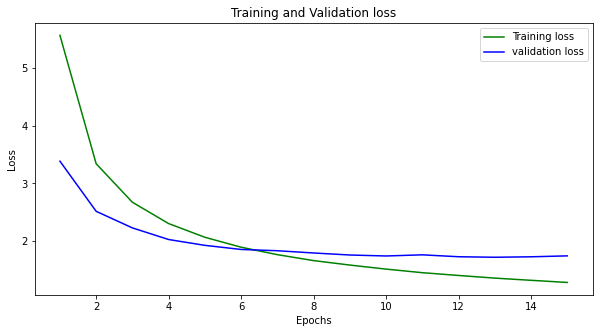

In [31]:
plot(lstm_train_loss, lstm_valid_loss)

## CNN Loss Function

In [0]:
cnn_train_loss = [5.623, 3.201, 2.453, 2.037, 1.780, 1.596, 1.460, 1.352, 1.269, 1.198, 1.134, 1.083, 1.034, 0.996, 0.959]
cnn_valid_loss = [3.422, 2.491, 2.186, 2.022, 1.955, 1.904, 1.840, 1.814, 1.783, 1.798, 1.780, 1.779, 1.795, 1.787, 1.768]

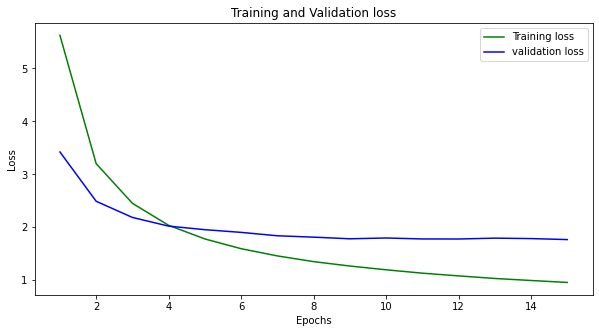

In [34]:
plot(cnn_train_loss, cnn_valid_loss)

## Transformer Loss Function

In [0]:
transformer_train_loss = [9.003, 5.817, 4.585, 3.782, 3.118, 2.612, 2.273, 2.017, 1.817, 1.660, 1.527, 1.420, 1.326, 1.241, 1.170]
transformer_valid_loss = [6.458, 4.890, 3.882, 3.312, 2.893, 2.675, 2.570, 2.439, 2.381, 2.337, 2.302, 2.275, 2.292, 2.241, 2.263]

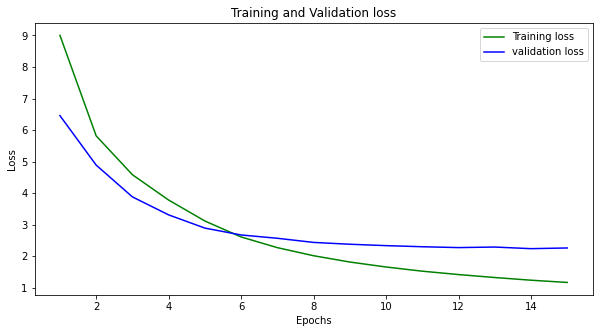

In [36]:
plot(transformer_train_loss, transformer_valid_loss)